In [1]:
import numpy as np
import pandas as pd
import scipy, scipy.signal

from datetime import date
import time

from random import seed
from random import random
import random
import os, os.path
import shutil

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

import matplotlib
import matplotlib.pyplot as plt
from pylab import imshow

import h5py
import sys
sys.path.append('/Users/hn/Documents/00_GitHub/Ag/NASA/Python_codes/')
import NASA_core as nc
# import NASA_plot_core.py as rcp

In [2]:
from tslearn.metrics import dtw as dtw_metric
# https://dtaidistance.readthedocs.io/en/latest/usage/dtw.html
from dtaidistance import dtw
from dtaidistance import dtw_visualisation as dtwvis

numpy.ndarray size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject


# Read Fields Metadata

In [3]:
meta_dir = "/Users/hn/Documents/01_research_data/NASA/parameters/"
meta = pd.read_csv(meta_dir+"evaluation_set.csv")
meta.head(2)

,ID,CropTyp,Irrigtn,DataSrc,Acres,ExctAcr,LstSrvD,county
0,100010_WSDA_SF_2017,alfalfa hay,center pivot,wsda,34,34.310305,2017/09/12,Grant
1,100204_WSDA_SF_2017,alfalfa hay,center pivot,wsda,62,61.826535,2017/08/09,Grant


In [4]:
meta_moreThan10Acr=meta[meta.ExctAcr>10]
print (meta.shape)
print (meta_moreThan10Acr.shape)

(6340, 8)
(3539, 8)


# Read Training Set Labels

In [5]:
training_set_dir = "/Users/hn/Documents/01_research_data/NASA/ML_data/"
ground_truth_labels = pd.read_csv(training_set_dir+"train_labels.csv")
print ("Unique Votes: ", ground_truth_labels.Vote.unique())
print (len(ground_truth_labels.ID.unique()))
ground_truth_labels.head(2)

Unique Votes:  [2 1]
1849


,ID,Vote
0,99837_WSDA_SF_2017,2
1,114615_WSDA_SF_2017,1


# Read the Data

In [6]:
VI_idx = "EVI"
data_dir = "/Users/hn/Documents/01_research_data/NASA/VI_TS/05_SG_TS/"

In [7]:
file_names = ["SG_Walla2015_" + VI_idx + "_JFD.csv", "SG_AdamBenton2016_" + VI_idx + "_JFD.csv", 
              "SG_Grant2017_" + VI_idx + "_JFD.csv", "SG_FranklinYakima2018_"+ VI_idx +"_JFD.csv"]

data=pd.DataFrame()

for file in file_names:
    curr_file=pd.read_csv(data_dir + file)
    curr_file['human_system_start_time'] = pd.to_datetime(curr_file['human_system_start_time'])
    
    # These data are for 3 years. The middle one is the correct one
    all_years = sorted(curr_file.human_system_start_time.dt.year.unique())
    if len(all_years)==3 or len(all_years)==2:
        proper_year = all_years[1]
    elif len(all_years)==1:
        proper_year = all_years[0]

    curr_file = curr_file[curr_file.human_system_start_time.dt.year==proper_year]
    data=pd.concat([data, curr_file])

data.reset_index(drop=True, inplace=True)
data.head(2)

,ID,human_system_start_time,EVI
0,135073_WSDA_SF_2015,2015-01-10,0.054429
1,135073_WSDA_SF_2015,2015-01-20,0.051731


In [8]:
ground_truth = data[data.ID.isin(list(ground_truth_labels.ID.unique()))].copy()

# Toss small fields

In [9]:
ground_truth = ground_truth[ground_truth.ID.isin((list(meta_moreThan10Acr.ID)))].copy()
ground_truth_labels = ground_truth_labels[ground_truth_labels.ID.isin((list(meta_moreThan10Acr.ID)))].copy()

# Sort the order of time-series and experts' labels identically

In [10]:
ground_truth.sort_values(by=["ID", 'human_system_start_time'], inplace=True)
ground_truth_labels.sort_values(by=["ID"], inplace=True)

ground_truth.reset_index(drop=True, inplace=True)
ground_truth_labels.reset_index(drop=True, inplace=True)

assert (len(ground_truth.ID.unique()) == len(ground_truth_labels.ID.unique()))

print (list(ground_truth.ID)[0])
print (list(ground_truth_labels.ID)[0])
print ("____________________________________")
print (list(ground_truth.ID)[-1])
print (list(ground_truth_labels.ID)[-1])
print ("____________________________________")
print (list(ground_truth.ID.unique())==list(ground_truth_labels.ID.unique()))

100048_WSDA_SF_2017
100048_WSDA_SF_2017
____________________________________
99909_WSDA_SF_2017
99909_WSDA_SF_2017
____________________________________
True


In [11]:
ground_truth.head(2)

,ID,human_system_start_time,EVI
0,100048_WSDA_SF_2017,2017-01-06,0.0
1,100048_WSDA_SF_2017,2017-01-16,0.0


In [12]:
ground_truth_labels.head(2)

,ID,Vote
0,100048_WSDA_SF_2017,1
1,100081_WSDA_SF_2017,1


In [13]:
mins = ground_truth.groupby("ID")[VI_idx].min()
maxs = ground_truth.groupby("ID")[VI_idx].max()
_ranges = maxs-mins
_ranges = pd.DataFrame(_ranges)
_ranges.reset_index(inplace=True)

mins = pd.DataFrame(mins)
mins.reset_index(inplace=True)


_ranges.rename(columns = {'EVI':'EVI_range'}, inplace = True)
mins.rename(columns = {'EVI':'EVI_min'}, inplace = True)

print (_ranges.head(2))

ground_truth = pd.merge(ground_truth, _ranges, on=['ID'], how='left')
ground_truth = pd.merge(ground_truth, mins, on=['ID'], how='left')
ground_truth["EVI_ratio"] = (ground_truth["EVI"]-ground_truth["EVI_min"])/ground_truth["EVI_range"]
ground_truth.head(2)

                    ID  EVI_range
0  100048_WSDA_SF_2017   0.542756
1  100081_WSDA_SF_2017   0.641120


,ID,human_system_start_time,EVI,EVI_range,EVI_min,EVI_ratio
0,100048_WSDA_SF_2017,2017-01-06,0.0,0.542756,-0.006879,0.012674
1,100048_WSDA_SF_2017,2017-01-16,0.0,0.542756,-0.006879,0.012674


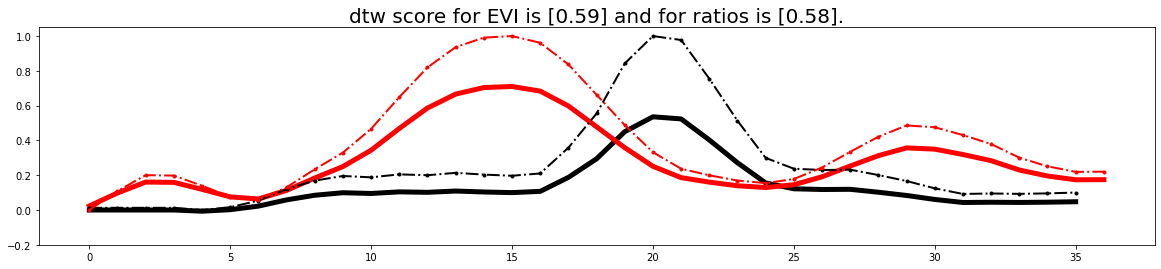

In [14]:
ID_1=ground_truth.ID.unique()[0]
ID_2=ground_truth.ID.unique()[12]

# _minimum = ground_truth[ground_truth.ID==ID_1].EVI.values.min()
# _range = ground_truth[ground_truth.ID==ID_1].EVI.values.max()-_minimum
# y_1 = (ground_truth[ground_truth.ID==ID_1].EVI.values-_minimum)/_range
# _minimum = ground_truth[ground_truth.ID==ID_2].EVI.values.min()
# _range = ground_truth[ground_truth.ID==ID_2].EVI.values.max()-_minimum
# y_2 = (ground_truth[ground_truth.ID==ID_2].EVI.values-_minimum)/_range

dtw_score = dtw_metric(ground_truth[ground_truth.ID==ID_1].EVI.values, 
                       ground_truth[ground_truth.ID==ID_2].EVI.values)

dtw_score_ratios = dtw_metric(ground_truth[ground_truth.ID==ID_1].EVI_ratio.values, 
                       ground_truth[ground_truth.ID==ID_2].EVI_ratio.values)

# print ("dtw score is {:.2f}.".format(dtw_score))

plt.figure(figsize=(20,4))
plt.subplot(1, 1, 1)

# plot EVIs
plt.plot(range(len(ground_truth[ground_truth.ID==ID_1].human_system_start_time.values)),
         ground_truth[ground_truth.ID==ID_1].EVI.values,
        c='k', linewidth=5);


plt.plot(range(len(ground_truth[ground_truth.ID==ID_2].human_system_start_time.values)),
         ground_truth[ground_truth.ID==ID_2].EVI.values,
        c='red', linewidth=5);

# plot ratios
plt.plot(range(len(ground_truth[ground_truth.ID==ID_1].human_system_start_time.values)), 
         ground_truth[ground_truth.ID==ID_1].EVI_ratio.values,
         ".-.", c='k', linewidth=2, label="ratios");

plt.plot(range(len(ground_truth[ground_truth.ID==ID_2].human_system_start_time.values)), 
         ground_truth[ground_truth.ID==ID_2].EVI_ratio.values,
         ".-.", c='red', linewidth=2, label="ratios");


title = "dtw score for EVI is [{:.2f}] and for ratios is [{:.2f}].".format(dtw_score, dtw_score_ratios)
plt.ylim([-0.2, 1.05]);
plt.title(title , fontsize = 20);

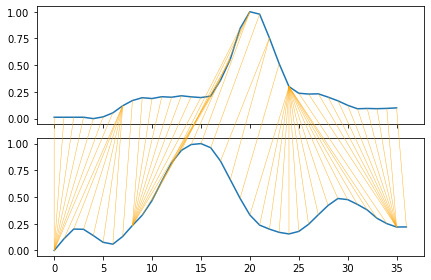

In [15]:
s1=ground_truth[ground_truth.ID==ID_1].EVI_ratio.values
s2=ground_truth[ground_truth.ID==ID_2].EVI_ratio.values
path = dtw.warping_path(s1, s2)
dtwvis.plot_warping(s1, s2, path)
distance = dtw.distance(s1, s2)

In [16]:
def DTW_prune(ts1, ts2):
    d,_ = dtw.warping_paths(ts1, ts2, window=10, use_pruning=True);
    return d
    

# Widen Ground Truth Table

In [17]:
EVI_colnames = [VI_idx + "_" + str(ii) for ii in range(1, 37) ]
columnNames = ["ID"] + EVI_colnames
ground_truth_wide = pd.DataFrame(columns=columnNames, 
                             index=range(len(ground_truth.ID.unique())))
ground_truth_wide["ID"] = ground_truth.ID.unique()

for an_ID in ground_truth.ID.unique():
    curr_df = ground_truth[ground_truth.ID==an_ID]
    
    ground_truth_wide_indx = ground_truth_wide[ground_truth_wide.ID==an_ID].index
    ground_truth_wide.loc[ground_truth_wide_indx, "EVI_1":"EVI_36"] = curr_df.EVI.values[:36]

In [18]:
ground_truth_wide.head(2)

,ID,EVI_1,EVI_2,EVI_3,EVI_4,EVI_5,EVI_6,EVI_7,EVI_8,EVI_9,...,EVI_27,EVI_28,EVI_29,EVI_30,EVI_31,EVI_32,EVI_33,EVI_34,EVI_35,EVI_36
0,100048_WSDA_SF_2017,0.0,0.0,0.0,0.0,-0.006879,0.00189,0.022394,0.058236,0.084847,...,0.117901,0.118943,0.10218,0.083567,0.060726,0.043216,0.044677,0.043529,0.044976,0.047556
1,100081_WSDA_SF_2017,0.061194,0.17806,0.314768,0.400648,0.372504,0.300225,0.248369,0.287094,0.38641,...,0.113426,0.129493,0.131741,0.106022,0.063932,0.038309,0.047011,0.076422,0.104836,0.107314


In [19]:
ground_truth_labels.shape

(1342, 2)

# Split Train and Test Set

#### Make sure rows of ```ground_truth_allBands``` and ```ground_truth_labels``` are in the same order

In [20]:
ground_truth_labels = ground_truth_labels.set_index('ID')
ground_truth_labels = ground_truth_labels.reindex(index=ground_truth_wide['ID'])
ground_truth_labels = ground_truth_labels.reset_index()

In [21]:
ground_truth_labels.head(2)

,ID,Vote
0,100048_WSDA_SF_2017,1
1,100081_WSDA_SF_2017,1


In [22]:
x_train_df, x_test_df, y_train_df, y_test_df = train_test_split(ground_truth_wide, 
                                                                ground_truth_labels, 
                                                                test_size=0.2, 
                                                                random_state=0,
                                                                shuffle=True,
                                                                stratify=ground_truth_labels.Vote.values)

# Train

In [23]:
%%time
parameters = {'n_neighbors':[2, 4, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 20],
              "weights":["uniform"]}
KNN_DTW_prune = GridSearchCV(KNeighborsClassifier(metric=DTW_prune), parameters, cv=5, verbose=1)
KNN_DTW_prune.fit(x_train_df.iloc[:, 1:], y_train_df.Vote.values)

Fitting 5 folds for each of 13 candidates, totalling 65 fits
CPU times: total: 5h 12min 32s
Wall time: 11h 2min 46s


GridSearchCV(cv=5,
             estimator=KNeighborsClassifier(metric=<function DTW_prune at 0x0000025B3985EB80>),
             param_grid={'n_neighbors': [2, 4, 8, 9, 10, 11, 12, 13, 14, 15, 16,
                                         17, 20],
                         'weights': ['uniform']},
             verbose=1)

In [24]:
print (KNN_DTW_prune.best_params_)

{'n_neighbors': 9, 'weights': 'uniform'}


In [25]:
x_test_df = x_test_df[x_test_df.ID.isin((list(meta_moreThan10Acr.ID)))].copy()
y_test_df = y_test_df[y_test_df.ID.isin((list(meta_moreThan10Acr.ID)))].copy()

In [51]:
%%time
KNN_DTW_prune_predictions_uniform = KNN_DTW_prune.predict(x_test_df.iloc[:, 1:])

CPU times: total: 7min 11s
Wall time: 7min 12s


In [52]:
(KNN_DTW_prune_predictions_uniform==y_test_df.Vote).sum()

260

# Definitions

  - **Precision** Of all instances we predict $\hat y = 1$, what fraction is actually 1.
     \begin{equation}\label{eq:precision}
        \text{Precision} = \frac{\text{TP}}{\text{TP} + \text{FP}}
     \end{equation}

  - **Recall** Of all instances that are actually $y = 1$, what fraction we predict 1.
     \begin{equation}\label{eq:recall}
         \text{Recall} = \text{TPR} = \frac{\text{TP}}{\text{TP} + \text{FN}}
     \end{equation}
     
  - **Specifity** Fraction of all negative instances that are incorrectly predicted positive.
     \begin{equation}\label{eq:specifity}
        \text{Specifity} = \text{FPR} = \frac{\text{FP}}{\text{TN} + \text{FP}}\\
     \end{equation}
     
  - **F-Score** Adjust $\beta$ for trade off between  precision and recall. For precision oriented task $\beta = 0.5$.
     \begin{equation}\label{eq:Fscore}
        F_\beta = \frac{(1+\beta^2) \times \text{TP}}{ (1+\beta^2) \times  \text{TP} + \beta^2 \text{FN} + \text{FP}}
     \end{equation}



In [53]:
y_test_df_copy_uniform=y_test_df.copy()
y_test_df_copy_uniform["KNN_DTW_prune_predictions_uniform"] = list(KNN_DTW_prune_predictions_uniform)
y_test_df_copy_uniform.head(2)

,ID,Vote,KNN_DTW_prune_predictions_uniform
1221,7667_WSDA_SF_2016,1,1
1334,99748_WSDA_SF_2017,1,1


In [55]:
true_single_predicted_single=0
true_single_predicted_double=0

true_double_predicted_single=0
true_double_predicted_double=0

for index in y_test_df_copy.index:
    curr_vote=list(y_test_df_copy[y_test_df_copy.index==index].Vote)[0]
    curr_predict=list(y_test_df_copy_uniform[y_test_df_copy.index==index].KNN_DTW_prune_predictions_uniform)[0]
    if curr_vote==curr_predict:
        if curr_vote==1:
            true_single_predicted_single+=1
        else:
            true_double_predicted_double+=1
    else:
        if curr_vote==1:
            true_single_predicted_double+=1
        else:
            true_double_predicted_single+=1

In [73]:
A = y_test_df_copy_uniform[y_test_df_copy_uniform.Vote==2]
A = A[A.KNN_DTW_prune_predictions_uniform==1]
meta[meta.ID.isin(list(A.ID))].ExctAcr.sum()

439.8096001755226

In [74]:
A = y_test_df_copy_uniform[y_test_df_copy_uniform.Vote==1]
A = A[A.KNN_DTW_prune_predictions_uniform==2]
meta[meta.ID.isin(list(A.ID))].ExctAcr.sum()

422.5279144711811

# Confusion Table for Test Set

In [56]:
confus_tbl_test_uniform = pd.DataFrame(columns=['NoName', 'Predict_Single', 'Predict_Double'], 
                               index=range(2))
confus_tbl_test_uniform.loc[0, 'NoName'] = 'Actual_Single'
confus_tbl_test_uniform.loc[1, 'NoName'] = 'Actual_Double'
confus_tbl_test_uniform['Predict_Single']=0
confus_tbl_test_uniform['Predict_Double']=0

confus_tbl_test_uniform.loc[0, "Predict_Single"]=true_single_predicted_single
confus_tbl_test_uniform.loc[0, "Predict_Double"]=true_single_predicted_double
confus_tbl_test_uniform.loc[1, "Predict_Single"]=true_double_predicted_single
confus_tbl_test_uniform.loc[1, "Predict_Double"]=true_double_predicted_double
confus_tbl_test_uniform

,NoName,Predict_Single,Predict_Double
0,Actual_Single,215,4
1,Actual_Double,5,45


In [57]:
print(classification_report(y_test_df.Vote, KNN_DTW_prune_predictions_uniform))

              precision    recall  f1-score   support

           1       0.98      0.98      0.98       219
           2       0.92      0.90      0.91        50

    accuracy                           0.97       269
   macro avg       0.95      0.94      0.94       269
weighted avg       0.97      0.97      0.97       269



In [33]:
print ("IF **Single** is positive and double is negative:")
print ("")

TP = list(confus_tbl_test[confus_tbl_test.NoName=="Actual_Single"]["Predict_Single"])[0]
FP = list(confus_tbl_test[confus_tbl_test.NoName=="Actual_Double"]["Predict_Single"])[0]
FN = list(confus_tbl_test[confus_tbl_test.NoName=="Actual_Single"]["Predict_Double"])[0]
print ("Precision is [{0:.2f}]".format(TP/(TP+FP)))
print ("Recall is [{0:.2f}]".format(TP/(TP+FN)))

print ("_________________________________________________________")
print ("IF **Single** is negative. double is positive:")

TP = list(confus_tbl_test[confus_tbl_test.NoName=="Actual_Double"]["Predict_Double"])[0]
FP = list(confus_tbl_test[confus_tbl_test.NoName=="Actual_Single"]["Predict_Double"])[0]
FN = list(confus_tbl_test[confus_tbl_test.NoName=="Actual_Double"]["Predict_Single"])[0]

print ("")
print ("Precision is [{0:.2f}]".format(TP/(TP+FP)))
print ("Recall is [{0:.2f}]".format(TP/(TP+FN)))

IF **Single** is positive and double is negative:

Precision is [0.98]
Recall is [0.98]
_________________________________________________________
IF **Single** is negative. double is positive:

Precision is [0.92]
Recall is [0.90]


# Export Trained Model

In [35]:
import pickle
model_dir = "/Users/hn/Documents/01_research_data/NASA/ML_Models/"

filename = model_dir + "00_KNN_SG_"+ VI_idx + "_DTW_prune_" + KNN_DTW_prune.best_params_["weights"] + "Weight_" + \
                        str(KNN_DTW_prune.best_params_["n_neighbors"]) + "NNisBest.sav"
print (filename)
pickle.dump(KNN_DTW_prune, open(filename, 'wb'))

In [36]:
# How to load the saved model:
# loaded_model_KNN_DTW_prune = pickle.load(open(filename, 'rb'))
# loaded_model.predict(x_test_df.iloc[0:2, 1:])

In [37]:
# %%time
# parameters = {'n_neighbors':[10]}
# KNN_DTW_prune_10NN = GridSearchCV(KNeighborsClassifier(metric=DTW_prune), parameters, cv=5, verbose=1);
# KNN_DTW_prune_10NN.fit(x_train_df.iloc[:, 1:], y_train_df.Vote.values);
# %%time
# KNN_DTW_prune_10NN_predictions = KNN_DTW_prune_10NN.predict(x_test_df.iloc[:, 1:])

# Improve

### Lets see if putting weights will make a difference

In [38]:
%%time
parameters = {'n_neighbors':[2, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
              "weights":["distance"]}
KNN_DTW_prune_weightsDistance = GridSearchCV(KNeighborsClassifier(metric=DTW_prune), 
                                             parameters, cv=5, verbose=1)
KNN_DTW_prune_weightsDistance.fit(x_train_df.iloc[:, 1:], y_train_df.Vote.values)

Fitting 5 folds for each of 17 candidates, totalling 85 fits
CPU times: total: 6h 45min 42s
Wall time: 6h 52min 19s


GridSearchCV(cv=5,
             estimator=KNeighborsClassifier(metric=<function DTW_prune at 0x0000025B3985EB80>),
             param_grid={'n_neighbors': [2, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14,
                                         15, 16, 17, 18, 19, 20],
                         'weights': ['distance']},
             verbose=1)

In [39]:
print ("KNN_DTW_prune_weightsDistance.best_params_ is", KNN_DTW_prune_weightsDistance.best_params_)
print ("KNN_DTW_prune.best_params_ is", KNN_DTW_prune.best_params_)

KNN_DTW_prune_weightsDistance.best_params_ is {'n_neighbors': 4, 'weights': 'distance'}
KNN_DTW_prune.best_params_ is {'n_neighbors': 9, 'weights': 'uniform'}


In [40]:
%%time
KNN_DTW_prune_weightsDistance_predictions = KNN_DTW_prune_weightsDistance.predict(x_test_df.iloc[:, 1:])

CPU times: total: 7min 38s
Wall time: 8min 6s


In [41]:
print ("******* KNN_DTW_prune_predictions *******")
print(classification_report(y_test_df.Vote, KNN_DTW_prune_predictions))
print ("====================================================================================")
print ("******* KNN_DTW_prune_weightsDistance_predictions *******")
print(classification_report(y_test_df.Vote, KNN_DTW_prune_weightsDistance_predictions))

******* KNN_DTW_prune_predictions *******
              precision    recall  f1-score   support

           1       0.98      0.98      0.98       219
           2       0.92      0.90      0.91        50

    accuracy                           0.97       269
   macro avg       0.95      0.94      0.94       269
weighted avg       0.97      0.97      0.97       269

******* KNN_DTW_prune_weightsDistance_predictions *******
              precision    recall  f1-score   support

           1       0.98      0.98      0.98       219
           2       0.92      0.90      0.91        50

    accuracy                           0.97       269
   macro avg       0.95      0.94      0.94       269
weighted avg       0.97      0.97      0.97       269



In [42]:
y_test_df_copy=y_test_df.copy()
y_test_df_copy["weightDist_predictions"] = list(KNN_DTW_prune_weightsDistance_predictions)
y_test_df_copy.head(2)

true_single_predicted_single=0
true_single_predicted_double=0

true_double_predicted_single=0
true_double_predicted_double=0

actual_double_predicted_single_IDs=[]
actual_single_predicted_double_IDs=[]

for index in y_test_df_copy.index:
    curr_vote=list(y_test_df_copy[y_test_df_copy.index==index].Vote)[0]
    curr_predict=list(y_test_df_copy[y_test_df_copy.index==index].weightDist_predictions)[0]
    if curr_vote==curr_predict:
        if curr_vote==1:
            true_single_predicted_single+=1
        else:
            true_double_predicted_double+=1
    else:
        if curr_vote==1:
            true_single_predicted_double+=1
            actual_single_predicted_double_IDs+=list(y_test_df_copy[y_test_df_copy.index==index].ID)
        else:
            true_double_predicted_single+=1
            actual_double_predicted_single_IDs += list(y_test_df_copy[y_test_df_copy.index==index].ID)

confus_tbl_test = pd.DataFrame(columns=['None', 'Predict_Single', 'Predict_Double'], 
                               index=range(2))
confus_tbl_test.loc[0, 'None'] = 'Actual_Single'
confus_tbl_test.loc[1, 'None'] = 'Actual_Double'
confus_tbl_test['Predict_Single']=0
confus_tbl_test['Predict_Double']=0

confus_tbl_test.loc[0, "Predict_Single"]=true_single_predicted_single
confus_tbl_test.loc[0, "Predict_Double"]=true_single_predicted_double
confus_tbl_test.loc[1, "Predict_Single"]=true_double_predicted_single
confus_tbl_test.loc[1, "Predict_Double"]=true_double_predicted_double
confus_tbl_test

,None,Predict_Single,Predict_Double
0,Actual_Single,215,4
1,Actual_Double,5,45


In [44]:
import pickle
model_dir = "/Users/hn/Documents/01_research_data/NASA/ML_Models/"

filename = model_dir + "00_KNN_SG_" + VI_idx + "_DTW_prune_" + \
                        KNN_DTW_prune_weightsDistance.best_params_["weights"] + \
                       "Weight_" + str(KNN_DTW_prune_weightsDistance.best_params_["n_neighbors"]) + \
                       "NNisBest.sav"

print (filename)
pickle.dump(KNN_DTW_prune_weightsDistance, open(filename, 'wb'))

In [45]:
actual_double_predicted_single_IDs

['60678_WSDA_SF_2016',
 '109262_WSDA_SF_2017',
 '104993_WSDA_SF_2017',
 '106509_WSDA_SF_2017',
 '104402_WSDA_SF_2018']

In [46]:
actual_single_predicted_double_IDs

['35343_WSDA_SF_2018',
 '101372_WSDA_SF_2017',
 '6873_WSDA_SF_2016',
 '55524_WSDA_SF_2016']

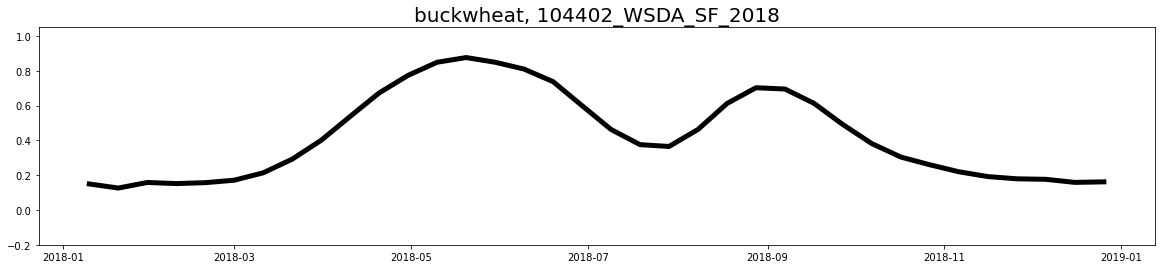

In [47]:
plt.figure(figsize=(20,4))
plt.subplot(1, 1, 1)

ID_1 = actual_double_predicted_single_IDs[4]
# plot EVI0
# plt.plot(range(len(ground_truth[ground_truth.ID==ID_1].human_system_start_time.values)),
#          ground_truth[ground_truth.ID==ID_1].EVI.values,
#         c='k', linewidth=5);

plt.plot(ground_truth[ground_truth.ID==ID_1].human_system_start_time.values,
         ground_truth[ground_truth.ID==ID_1].EVI.values,
         c='k', linewidth=5);


title = list(meta[meta.ID==ID_1].CropTyp)[0].replace(",", "")  + ", " + ID_1
plt.ylim([-0.2, 1.05]);
plt.title(title , fontsize=20);

In [48]:
meta[meta.ID.isin(actual_double_predicted_single_IDs)]

,ID,CropTyp,Irrigtn,DataSrc,Acres,ExctAcr,LstSrvD,county
1928,60678_WSDA_SF_2016,"bean, dry",center pivot,wsda,32,32.322881,2016/08/17 00:00:00,Adams
2103,104402_WSDA_SF_2018,buckwheat,center pivot,wsda,151,151.414756,2018/09/11 00:00:00,Franklin
2700,104993_WSDA_SF_2017,"corn, field",center pivot,wsda,105,105.329378,2017/06/28,Grant
2755,109262_WSDA_SF_2017,"corn, field",center pivot,wsda,26,25.597377,2017/10/18,Grant
6325,106509_WSDA_SF_2017,yellow mustard,center pivot,wsda,135,134.651954,2017/10/17,Grant


In [49]:
meta[meta.ID.isin(actual_single_predicted_double_IDs)]

,ID,CropTyp,Irrigtn,DataSrc,Acres,ExctAcr,LstSrvD,county
2070,55524_WSDA_SF_2016,bluegrass seed,center pivot,wsda,141,140.849153,2016/08/03 00:00:00,Adams
2153,101372_WSDA_SF_2017,canola,center pivot,wsda,80,80.255504,2017/10/16,Grant
3116,6873_WSDA_SF_2016,"corn, sweet",center pivot,producer,57,57.302292,2016/12/15 00:00:00,Benton
3870,35343_WSDA_SF_2018,grass hay,wheel line,wsda,15,15.047502,2018/12/03 00:00:00,Yakima


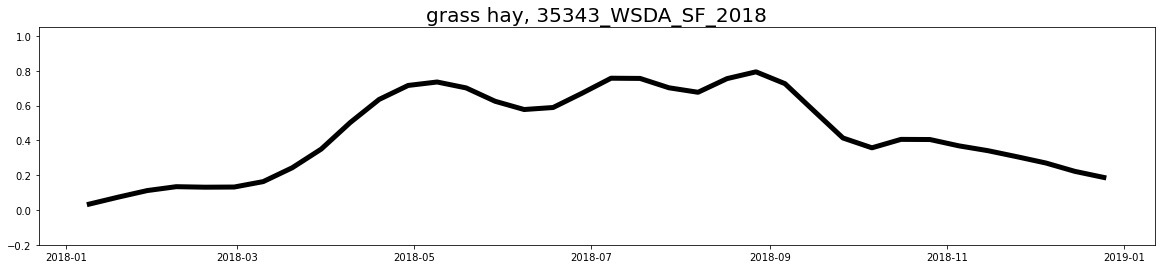

In [50]:
plt.figure(figsize=(20,4))
plt.subplot(1, 1, 1)

ID_1 = actual_single_predicted_double_IDs[0]
# plot EVIs
# plt.plot(range(len(ground_truth[ground_truth.ID==ID_1].human_system_start_time.values)),
#          ground_truth[ground_truth.ID==ID_1].EVI.values,
#         c='k', linewidth=5);

plt.plot(ground_truth[ground_truth.ID==ID_1].human_system_start_time.values,
         ground_truth[ground_truth.ID==ID_1].EVI.values,
        c='k', linewidth=5);


title = list(meta[meta.ID==ID_1].CropTyp)[0].replace(",", "")  + ", " + ID_1
plt.ylim([-0.2, 1.05]);
plt.title(title , fontsize = 20);